# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [4]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score
from time import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sys
import seaborn as sns

In [5]:
portfolio.shape

(10, 6)

In [6]:
profile.shape

(17000, 5)

In [7]:
transcript.shape

(306534, 4)

In [8]:
portfolio.head(5)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [9]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [10]:
def horizontal_bar_plot(df, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltfigsize: The figure size of the plot (default is [5,5]).
    
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    
    fntSize: The font size of text (default to 12 point font size)
    
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = df[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

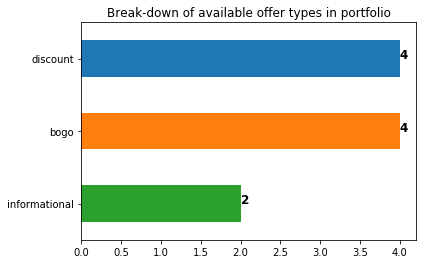

In [11]:
horizontal_bar_plot(portfolio, 'offer_type', "Break-down of available offer types in portfolio")

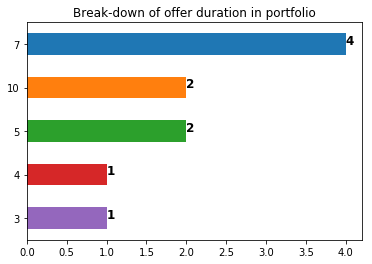

In [12]:
horizontal_bar_plot(portfolio, 'duration', "Break-down of offer duration in portfolio")

In [13]:
#We can see from above that the portfolio table consists of 10 not-null entries that contains information about the offers provided by starbucks. It has channels through which the specific offers are deployed which consists of elements in a list, which has to be handled later in the process.
#Finally, We can see a histogram containing a distribution of 3 offer types totalling in 10 entries.
#This table needs to be cleaned and in the next session this will be done in the next phase.

In [14]:
#Profile

In [15]:
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [17]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

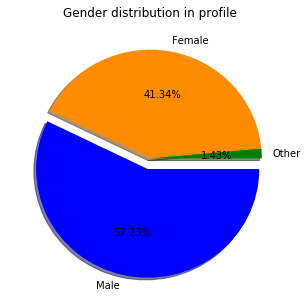

In [18]:
exploded_pie_plot(profile, 'gender', 'Gender distribution in profile', ['blue', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

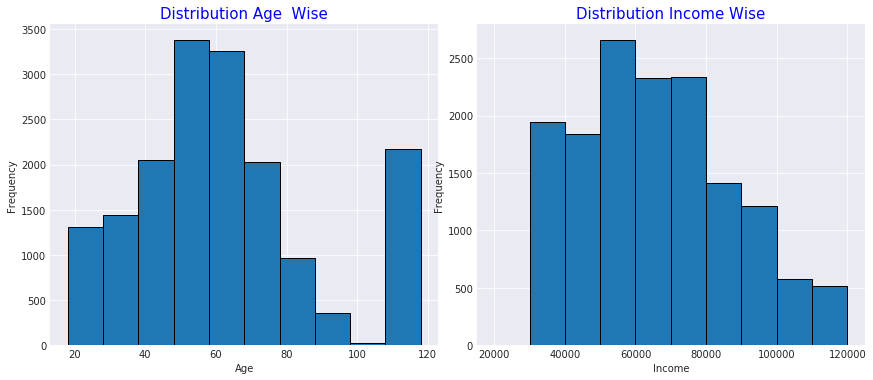

In [19]:
#Creating Subplots for distribution based on Gender,Age and Income
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()

# AGE BASED
profile.age.plot.hist(ax=ax[0],fontsize=10,edgecolor='black') 
ax[0].set_title("Distribution Age  Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Age", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
profile.income.plot.hist(ax=ax[1],fontsize=10,edgecolor='black',range=(20000, 120000)) 
ax[1].set_title("Distribution Income Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Income", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()

We can see from above that the profile table consists of 17000 entries with some null elements in the columns gender and income. Also, from the dashboard above we can see the distribution of the members according to gender, age and income. We can also see that with respect to the distribution according to the gender, the frequency of males is more than the female with little population towards others. Secondly, while looking at age-wise distribution it is evident that the age group from 50-70 is the highest. Finally, while looking at the income-wise distribution, members with income ranging from 40k- 80k are high than others. We need to clean this profile table as it contains all values as well as the age value of 118 which has a lot of frequency and it is due to some data entry

In [20]:
#Transcript

In [21]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [24]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

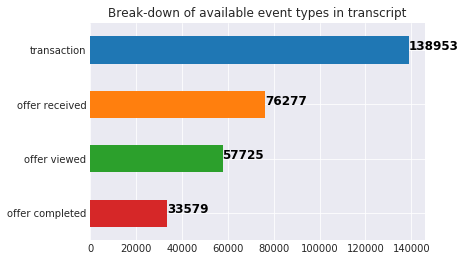

In [26]:
horizontal_bar_plot(transcript, 'event', "Break-down of available event types in transcript")
rotation='vertical'

As It has been seen that this table consists of 306534 entries which are all populated and contain no null values. However, this table needs to be cleaned and the offer should be extracted based on the id while simultaneously classifying it based on the completion, view, and received. This will be done in the data cleaning phase.

## 1- Data Cleaning

### Profile

In [27]:
def clean_profile(profile = profile):
    """
    Takes the dataframe profile and cleans it by creating one-hot encodings as well as handling null values and  error age value 118.
    
    PARAMETERS:
        Profile dataframe.
        
    RETURNS:
        A new dataframe whithout income values iqual to null and age iqual to 118 as well as one hot encoded columns.
    """
    # drop lines with income = nan and age == 118
    new_df = profile.drop(profile[(profile["income"].isnull()) & (profile["age"] == 118)].index)
    
    # One-hot encode Gender column
    gender_dummies = pd.get_dummies(new_df["gender"])
    
    # Specifying age range and one hot encoding
    range_ages = pd.cut(x=new_df["age"], bins=[18, 20, 29, 39, 49, 59, 69, 79, 89, 99, 102])
    # One-hot encode ages column
    ages_dummies = pd.get_dummies(range_ages)
    
    # Specifying income range and one hot encoding
   
    range_income = pd.cut(x=new_df["income"], bins=[30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000,  120000])
    income_dummies = pd.get_dummies(range_income)
    

    # Concat
    new_df = pd.concat([new_df, ages_dummies, income_dummies, gender_dummies], axis=1, sort=False)
    
    # Dropping age,gender,income column
    new_df = new_df.drop(["age", "gender", "income"], axis=1)
    
    return new_df

In [28]:
cleaned_profile = clean_profile()
cleaned_profile.head()

,became_member_on,id,"(18, 20]","(20, 29]","(29, 39]","(39, 49]","(49, 59]","(59, 69]","(69, 79]","(79, 89]",...,"(50000, 60000]","(60000, 70000]","(70000, 80000]","(80000, 90000]","(90000, 100000]","(100000, 110000]","(110000, 120000]",F,M,O
1,20170715,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,20170509,78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
5,20180426,e2127556f4f64592b11af22de27a7932,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
8,20180209,389bc3fa690240e798340f5a15918d5c,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
12,20171111,2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


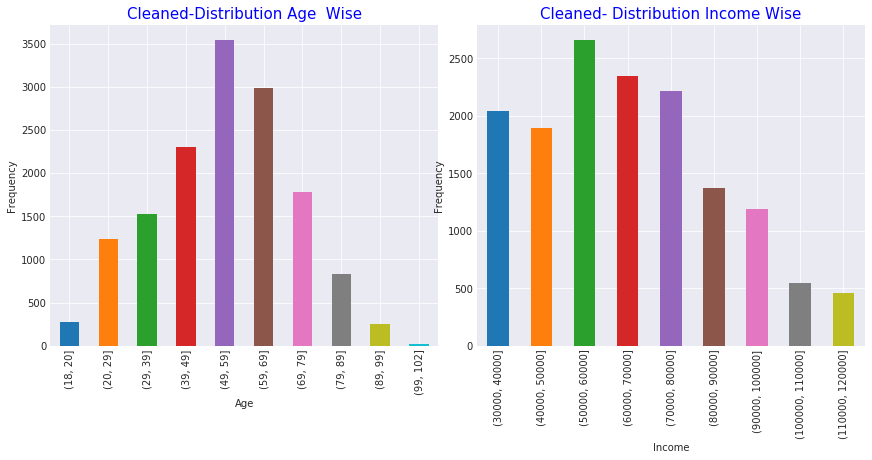

In [29]:
#Creating Subplots for distribution based on Age and Income for the Newly cleaned Profile data
sns.set_style('darkgrid')
fig,ax= plt.subplots(1,2,sharex=False, sharey=False,figsize=(12,5))
fig.tight_layout()


# AGE BASED
cleaned_profile[cleaned_profile.columns[2:12]].sum().plot.bar(ax=ax[0],fontsize=10) 
ax[0].set_title("Cleaned-Distribution Age  Wise", fontsize=15,color='blue')
ax[0].set_xlabel("Age", fontsize=10)
ax[0].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)

# INCOME BASED
cleaned_profile[cleaned_profile.columns[12:21]].sum().plot.bar(ax=ax[1],fontsize=10) 
ax[1].set_title("Cleaned- Distribution Income Wise", fontsize=15,color='blue')
ax[1].set_xlabel("Income", fontsize=10)
ax[1].set_ylabel("Frequency", fontsize=10)
sns.despine(bottom=True, left=True)
plt.show()

In [30]:
def exploded_pie_plot(df, colName, pltTitle, pltColors=[], pltLabels=[], pltExplode=(), pltFigSize=[5, 5]):
    """
    Creates an exploded pie plot with percentages of each categories for the column provided.
    
    Parameters
    ----------
    df: The dataframe with categories.
    
    colName: The name of the column containing the categories.
    
    pltTitle: The plot title.
    
    pltColors: The array of colors to use.
    
    pltLabels: The array of plot labels to use for each of the categories.
    
    pltExplode: The proportions to pass in for exploding the slices (e.g. 0.1, 0, 0 will explode the first category out by 10%)
    
    pltFigSize: The figure size of the plot (default is [5,5])
    
    Returns
    -------
    None
    """
    plt.figure(figsize=[5, 5])
    pltValues = df[colName].value_counts()
    colors = pltColors
    labels = pltLabels
    explode = pltExplode # if (0.1, 0, 0) then explode 1st slice by 10% and dont explode 2nd and 3rd slizes
    plt.pie(pltValues, colors=pltColors, labels=pltLabels, explode=pltExplode, autopct='%1.2f%%', counterclock=False, shadow=True)
    plt.title(pltTitle)

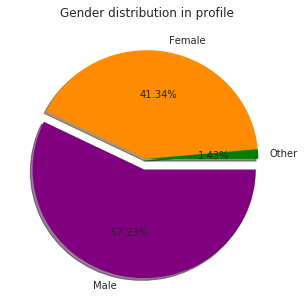

In [31]:
exploded_pie_plot(profile, 'gender', 'Gender distribution in profile', ['purple', 'darkorange', 'green'], ['Male', 'Female', 'Other'], (0.1, 0, 0))

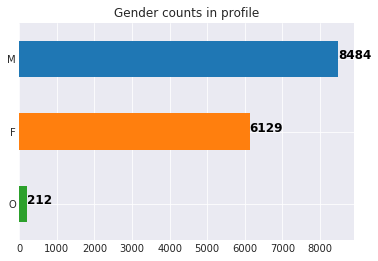

In [32]:
horizontal_bar_plot(profile, 'gender', "Gender counts in profile")

### Portfolio

In [33]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [34]:
#rename columns
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = rename_cols(portfolio, new_cols_name )

In [35]:
cleaned_portfolio.head()

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [36]:
cleaned_portfolio.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward'],
      dtype='object')

### Transcript

In [37]:
# Functions to create offer id and amount columns from the transcript table.
def create_offer_id_column(val):
    if list(val.keys())[0] in ['offer id', 'offer_id']:
        return list(val.values())[0]
    
def create_amount_column(val):
    if list(val.keys())[0] in ["amount"]:
        return list(val.values())[0]
    

In [38]:
def clean_transcript(transcript = transcript):
    """
    Cleans the Transcript table by setting one hot encoding values.
    PARAMETERS:
        transcript dataframe
    
    RETURNS:
        Cleaned transcript  dataframe
    
    """
    #
    transcript['offer_id'] = transcript.value.apply(create_offer_id_column)
    transcript['amount'] = transcript.value.apply(create_amount_column)
    
    #  One-hot encode event column
    event = pd.get_dummies(transcript['event'])
    
    # Concat one-hot and df
    new_df = pd.concat([transcript, event], axis=1, sort=False)
    
    # Create and Drop Transaction
    transaction = new_df[new_df["transaction"]==1]
    new_df = new_df.drop(transaction.index)
    
    # Drop
    new_df = new_df.drop(columns = ["event","value", "amount", "transaction"])
    
    return new_df

In [41]:
cleaned_transcript = clean_transcript()
cleaned_transcript.head()

,person,time,offer_id,offer completed,offer received,offer viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0


In [42]:
cleaned_transcript[cleaned_transcript['offer completed']==1].shape

(33579, 6)

# Extra Data Analysing / Preparing Data

### Portfolio

In [43]:
def rename_cols(df, new_cols_name):
    """
    Parameters
    ----------
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Returns
    -------
    df: output data frame with renamed column names
       
    """

    df= df.rename(columns = new_cols_name)
    return df

In [44]:
#rename columns
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
prepared_portfolio = rename_cols(portfolio, new_cols_name )

In [46]:
prepared_portfolio.head(7)

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2


In [47]:
prepared_portfolio.columns

Index(['channels', 'offer_difficulty', 'offer_duration', 'offer_id',
       'offer_type', 'offer_reward'],
      dtype='object')

## Preparing the profile

In [48]:
#rename columns
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
prepared_profile = rename_cols(profile, cols_profile )

In [49]:
prepared_profile.columns

Index(['age', 'became_member_on', 'gender', 'customer_id', 'customer_income'], dtype='object')

In [50]:
def preparing_profile(df):
    """
    preparing the profile data frame as per tasks 2-4
        
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per tasks
    """
    
    
    #deal with null values
    #replace 118 age values with NaN so to replace them easily with mean age
    df.replace(118, np.nan , inplace=True)
    #replace NaN age values with mean age
    df['age'] = df['age'].fillna(df['age'].mean())
    #replace missing income values with mean income
    df['customer_income'] = df['customer_income'].fillna(df['customer_income'].mean())
    #replace missing gender values with mode i.e. most frequent gender
    mode = df['gender'].mode()[0]
    df['gender'] = df['gender'].fillna(mode)
    
    #remove outliers
    df = df[df['age'] <= 80]
    df['age'] = df['age'].astype(int)
    
    #add Age_group column
    df.loc[(df.age < 20) , 'Age_group'] = 'Under 20'
    df.loc[(df.age >= 20) & (df.age <= 45) , 'Age_group'] = '20-45'
    df.loc[(df.age >= 46) & (df.age <= 60) , 'Age_group'] = '46-60'
    df.loc[(df.age >= 61) , 'Age_group'] = '61-80'
    df.drop('age',axis=1,inplace=True)
    return df

In [51]:
prepared_profile = preparing_profile(prepared_profile)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [52]:
prepared_profile

,became_member_on,gender,customer_id,customer_income,Age_group
0,20170212,M,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,46-60
1,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,46-60
2,20180712,M,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,46-60
3,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,61-80
4,20170804,M,a03223e636434f42ac4c3df47e8bac43,65404.991568,46-60
5,20180426,M,e2127556f4f64592b11af22de27a7932,70000.000000,61-80
6,20170925,M,8ec6ce2a7e7949b1bf142def7d0e0586,65404.991568,46-60
7,20171002,M,68617ca6246f4fbc85e91a2a49552598,65404.991568,46-60
8,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.000000,61-80
9,20161122,M,8974fc5686fe429db53ddde067b88302,65404.991568,46-60


In [53]:
prepared_profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16014 entries, 0 to 16999
Data columns (total 5 columns):
became_member_on    16014 non-null int64
gender              16014 non-null object
customer_id         16014 non-null object
customer_income     16014 non-null float64
Age_group           16014 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 750.7+ KB


In [54]:
#check for missing values 
prepared_profile.isnull().sum()

became_member_on    0
gender              0
customer_id         0
customer_income     0
Age_group           0
dtype: int64

In [55]:
prepared_profile.shape

(16014, 5)

we don't have any null values as cleaning profile data frame phase is complete now.

## Preparing Transcript

In [56]:
#rename columns
transcript_cols = {'person':'customer_id'}
prepared_transcript = rename_cols(transcript, transcript_cols)

In [57]:
prepared_transcript.columns

Index(['event', 'customer_id', 'time', 'value', 'offer_id', 'amount'], dtype='object')

In [58]:
def preparing_transcript(df):
    """
    preparing the transcript data frame as per task 2.
    
    Parameters
    ----------   
    df: data frame
    
    Returns
    -------
    df: output data frame as per task
    
    New column names given for expanded keys
    -------
    money_gained : money gained from "offer completed"
    money_spent : money spent in "transaction"
    offer_id 
    """
    
    #expand the dictionary to coulmns 
    df['offer_id'] = df['value'].apply(lambda x: x.get('offer_id'))
    df['offer id'] = df['value'].apply(lambda x: x.get('offer id'))
    df['money_gained'] = df['value'].apply(lambda x: x.get('reward'))
    df['money_spent'] = df['value'].apply(lambda x: x.get('amount'))
    
    #move 'offer id' values into 'offer_id'
    df['offer_id'] = df.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
    #drop 'offer id' column 
    df.drop(['offer id' , 'value'] , axis=1, inplace=True)
    #replace nan
    df.fillna(0 , inplace=True)
    
    return df

In [59]:
prepared_transcript = preparing_transcript(prepared_transcript)

In [60]:
prepared_transcript.head(7)

,event,customer_id,time,offer_id,amount,money_gained,money_spent
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,0.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0,0.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0,0.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0,0.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0,0.0
5,offer received,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0,0.0
6,offer received,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0,0.0


In [61]:
prepared_transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 7 columns):
event           306534 non-null object
customer_id     306534 non-null object
time            306534 non-null int64
offer_id        306534 non-null object
amount          306534 non-null float64
money_gained    306534 non-null float64
money_spent     306534 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 16.4+ MB


# Extra Data Analysis and Merging The Dataframes

In [65]:
def merge_data(portfolio,profile,transcript):
    """
    Merge cleaned data frames for EDA
       
    Parameters
    ---------- 
    portfolio : cleaned portfolio data frame
    profile : cleaned profile data frame
    transcript : cleaned transcript data frame
      
    Returns
    -------
    merged_df: merged data frame
    
    """
    
    merged_df = pd.merge(portfolio, transcript, on='offer_id')
    merged_df = pd.merge(merged_df, profile, on='customer_id')
    
    return merged_df

In [66]:
merged_df = merge_data(prepared_portfolio, prepared_profile, prepared_transcript)

In [67]:
merged_df.head(7)

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,amount,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,10.0,0.0,20170909,M,100000.0,61-80
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,0.0,20170909,M,100000.0,61-80
6,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,0.0,20170909,M,100000.0,61-80


There are few questions, we'll be discovering and analysing them.

#### -Let's see the average income of customers using the app

In [68]:
merged_df['customer_income'].mean()

65924.491099765321

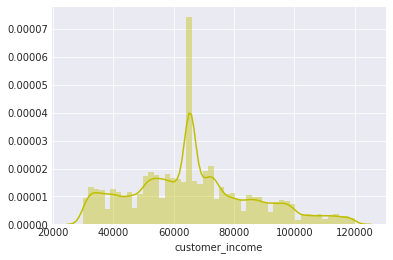

In [69]:
sns.distplot(merged_df['customer_income'], bins=50, color="y", hist_kws={'alpha': 0.4});

#### -Let's look at age distribution of customers

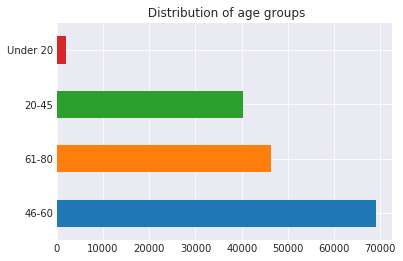

In [70]:
merged_df['Age_group'].value_counts().plot.barh(title=' Distribution of age groups')
rotation='vertical'

According to this data set, the group which is 46-60 years are the most active user of the app.

#### - Let's have a look at actions to the offers 

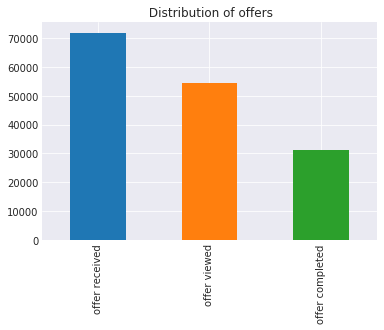

In [71]:
merged_df['event'].value_counts().plot.bar(title=' Distribution of offers')

This implies most of the customers who don't pay attention to the offer. Also, there are more number of customers who just view & ignore the offer than the one's who actually complete the offer.


#### -For a better analysis, let us analyze the data based on gender.

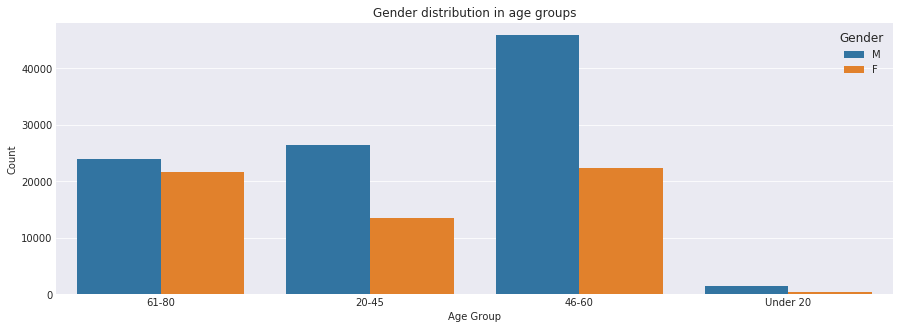

In [72]:
plot_gender = merged_df[merged_df['gender'] != 'O']
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

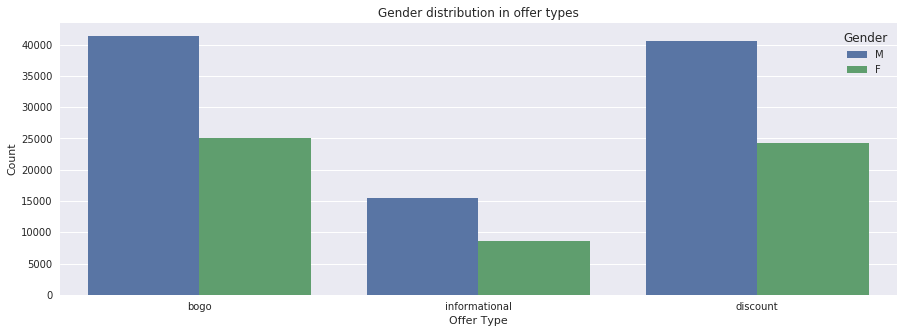

In [73]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="whitegrid")
plt.title('Gender distribution in offer types')
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

-Let's check the actions to the offers that males & females received

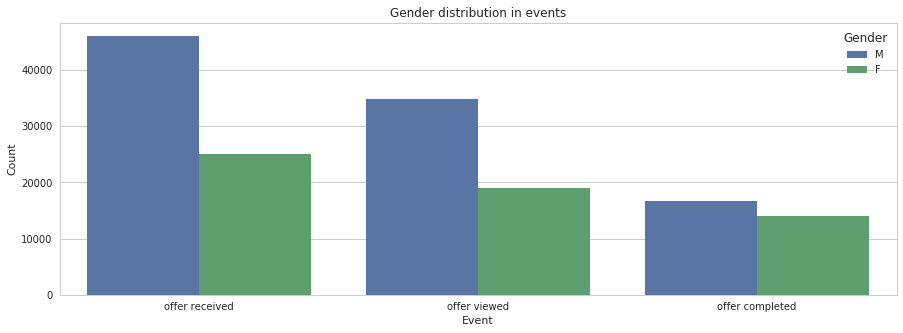

In [74]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Gender distribution in events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

-Actions to the offers in each age group

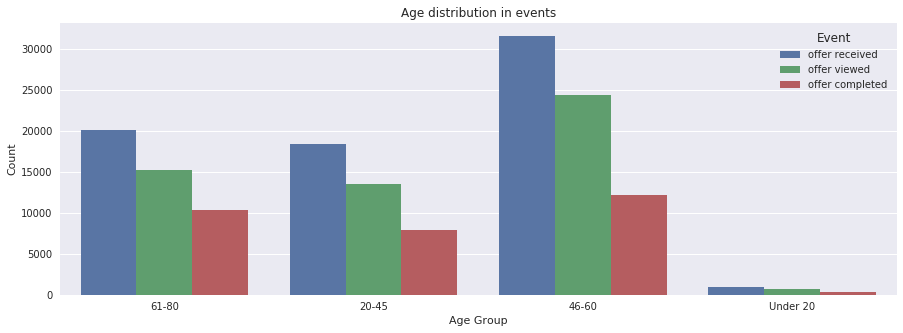

In [75]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.title('Age distribution in events')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

# Building a Machine Learning model to predict response of a customer

## Data Preparation and Cleaning for modelling

In [78]:
merged_df.head(7)

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward,event,customer_id,time,amount,money_gained,money_spent,became_member_on,gender,customer_income,Age_group
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,0.0,0.0,0.0,20170909,M,100000.0,61-80
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,102,0.0,0.0,0.0,20170909,M,100000.0,61-80
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,504,0.0,0.0,0.0,20170909,M,100000.0,61-80
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,0.0,0.0,20170909,M,100000.0,61-80
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer completed,4b0da7e80e5945209a1fdddfe813dbe0,510,0.0,10.0,0.0,20170909,M,100000.0,61-80
5,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer received,4b0da7e80e5945209a1fdddfe813dbe0,408,0.0,0.0,0.0,20170909,M,100000.0,61-80
6,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,offer viewed,4b0da7e80e5945209a1fdddfe813dbe0,468,0.0,0.0,0.0,20170909,M,100000.0,61-80


In [79]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157503 entries, 0 to 157502
Data columns (total 16 columns):
channels            157503 non-null object
offer_difficulty    157503 non-null int64
offer_duration      157503 non-null int64
offer_id            157503 non-null object
offer_type          157503 non-null object
offer_reward        157503 non-null int64
event               157503 non-null object
customer_id         157503 non-null object
time                157503 non-null int64
amount              157503 non-null float64
money_gained        157503 non-null float64
money_spent         157503 non-null float64
became_member_on    157503 non-null int64
gender              157503 non-null object
customer_income     157503 non-null float64
Age_group           157503 non-null object
dtypes: float64(4), int64(5), object(7)
memory usage: 20.4+ MB


#### TASKS

In [80]:
def cleaning_final_data(df):
    """
    Clean merged data frame for the final data as per tasks 1-5.
    
    Parameters
    ----------
    df: input data frame
    
    Returns
    -------
    df: cleaned data frame as per tasks
       
    """
    #process categorical variables
    categorical = ['offer_type', 'gender', 'Age_group']
    df = pd.get_dummies(df, columns = categorical)
    #process channels column 
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #process became_member_on column
    #change datatype of became_member_on 
    df['became_member_on'] = df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
    #add new columns for month & year
    df['month_member'] = df['became_member_on'].apply(lambda x: x.day)
    df['year_member'] = df['became_member_on'].apply(lambda x: x.year)
    #drop became_member_on column
    df.drop('became_member_on',axis=1, inplace=True)    
    
    #process offer_id column
    offerids = df['offer_id'].unique().tolist()
    o_mapping = dict( zip(offerids,range(len(offerids))) )
    df.replace({'offer_id': o_mapping},inplace=True)
    
    #process customer_id column
    cusids = df['customer_id'].unique().tolist()
    c_mapping = dict( zip(cusids,range(len(cusids))) )
    df.replace({'customer_id': c_mapping},inplace=True)
    
    #process numerical variables
    #initialize a MinMaxScaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
    df[numerical] = scaler.fit_transform(df[numerical])
    
    #encode 'event' data to numerical values according to task 2
    df['event'] = df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    
    return df

In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
import warnings

In [82]:
cleaned_data = cleaning_final_data(merged_df)

In [83]:
cleaned_data.columns

Index(['offer_difficulty', 'offer_duration', 'offer_id', 'offer_reward',
       'event', 'customer_id', 'time', 'amount', 'money_gained', 'money_spent',
       'customer_income', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'gender_F', 'gender_M', 'gender_O',
       'Age_group_20-45', 'Age_group_46-60', 'Age_group_61-80',
       'Age_group_Under 20', 'email', 'mobile', 'social', 'web',
       'month_member', 'year_member'],
      dtype='object')

In [84]:
cleaned_data.head(7)

,offer_difficulty,offer_duration,offer_id,offer_reward,event,customer_id,time,amount,money_gained,money_spent,...,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,0.5,0.571429,0,1.0,1,0,0.000000,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,9,2017
1,0.5,0.571429,0,1.0,2,0,0.142857,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,9,2017
2,0.5,0.571429,0,1.0,1,0,0.705882,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,9,2017
3,0.5,0.571429,0,1.0,2,0,0.714286,0.0,0.0,0.0,...,0,0,1,0,1,1,1,0,9,2017
4,0.5,0.571429,0,1.0,3,0,0.714286,0.0,1.0,0.0,...,0,0,1,0,1,1,1,0,9,2017
5,0.0,0.142857,1,0.0,1,0,0.571429,0.0,0.0,0.0,...,0,0,1,0,1,1,0,1,9,2017
6,0.0,0.142857,1,0.0,2,0,0.655462,0.0,0.0,0.0,...,0,0,1,0,1,1,0,1,9,2017


In [85]:
cleaned_data.shape

(157503, 27)

In [86]:
cleaned_data.event.value_counts()

1    71863
2    54396
3    31244
Name: event, dtype: int64

# Splitting the data as train and test

In [87]:
data = cleaned_data.drop('event', axis=1)
label = cleaned_data['event']

In [88]:
#Splitting the dataset as %70 Train and %30 Test
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 0)

print("Training set: {} rows".format(X_train.shape[0]))
print("Testing set: {} rows".format(X_test.shape[0]))

Training set: 110252 rows
Testing set: 47251 rows


### Training and Testing

Metrics: The F1 score will be considered as the model metric to assess the quality of the approach and determine which model gives the best results. It can be interpreted as the weighted average of the precision and recall. The traditional or balanced F-score (F1 score) is the harmonic mean of precision and recall, where an F1 score reaches its best value at 100 and worst at 0.

In [89]:
def train_test(clf):
    """
    Return train and test F1 score along with the model name
       
    Parameters
    --------
    clf: estimator instance
    
    Returns
    --------
    train_f1: train data F1 score
    test_f1: test data F1 score
    name: model name
       
    """
    train_prediction =  (clf.fit(X_train, y_train)).predict(X_train)
    test_predictions = (clf.fit(X_train, y_train)).predict(X_test)
    train_f1 =  accuracy_score(y_train, train_prediction)*100
    test_f1= fbeta_score(y_test, test_predictions, beta = 0.5, average='micro' )*100
    name = clf.__class__.__name__
    
    return train_f1, test_f1, name

In [90]:
##RandomForestClassifier

In [91]:
clf_B = RandomForestClassifier(random_state = 10)
b_train_f1, b_test_f1, b_model = train_test(clf_B)

In [92]:
##DecisionTreeClassifier

In [93]:
clf_C = DecisionTreeClassifier(random_state = 10)
c_train_f1, c_test_f1, c_model = train_test(clf_C)

In [94]:
##KNeighborsClassifier

In [95]:
clf_A = KNeighborsClassifier(n_neighbors = 5)
a_train_f1, a_test_f1, a_model = train_test(clf_A)

In [96]:
knn = {'Benchmark Model': [ a_model], 'train F1 score':[a_train_f1], 'test F1 score': [a_test_f1]}
benchmark = pd.DataFrame(knn)

In [97]:
benchmark

,Benchmark Model,train F1 score,test F1 score
0,KNeighborsClassifier,53.005841,30.947493


### Conclusions

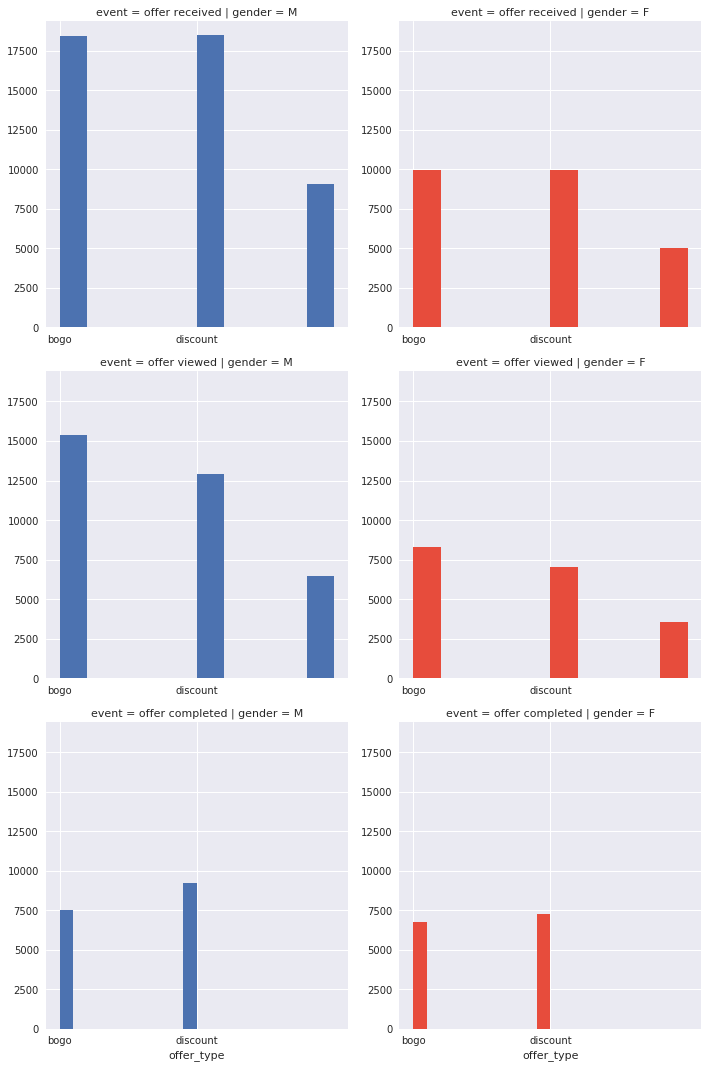

In [98]:
d = {'color': ['C0', "#e74c3c"]}
g = sns.FacetGrid(plot_gender, row='event', col='gender', hue_kws=d, hue='gender', size=5)
g.map(plt.hist, 'offer_type')

When we see the results that the males represent 57.3% of the data and use the Starbucks app more than the females. Specifically, both males & females in the age group 46-60 use apps the most. Discount offers are more preferred by the customers. Also, there is less number of customers who actually complete the offer as compared to the ones who just view & ignore it. We can look more at the figures & information in section- iii) Exploratory Data Analysis (points 1-10) to best determine which kind of offers to send to the customers.

In [99]:
models = {'Model': ['KNeighborsClassifier (Benchmark)', b_model, c_model], 
          'train F1 score ':[a_train_f1, b_train_f1, c_train_f1], 
          'test F1 score': [a_test_f1 , b_test_f1, c_test_f1] }
          
results = pd.DataFrame(models)

In [100]:
results

,Model,train F1 score,test F1 score
0,KNeighborsClassifier (Benchmark),53.005841,30.947493
1,RandomForestClassifier,93.669049,69.285306
2,DecisionTreeClassifier,94.703044,84.863812


The validation test data set is used to evaluate the model. Both the models are better than the benchmark. The best score is created by the DecisionTreeClassifier model, as its validated F1 score is 84.86, which is much higher than the benchmark. The RandomForestClassifier model scores well as well compared to the benchmark, with a test F1 score of 69.28. Our problem to solve is not that sensitive which requires a very high F1 score, so the scores are good & sufficient and can be used for the classification purpose to predict whether a customer will respond to an offer.